In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [80]:
def er_polarization(rates, weights, alpha=0.25, K=1000):
    """Esteban and Ray Polarization (1994)

    Parameters
    ----------
    rates : _type_
        _description_
    weights : _type_
        _description_
    alpha : float, optional
        _description_, by default 0.25
    K : int, optional
        _description_, by default 1000

    Returns
    -------
    _type_
        _description_
    """
    xx = np.multiply.outer(weights ** (1 + alpha), weights)
    yy = np.absolute(np.subtract.outer(rates, rates))
    # avg = np.average(rates, weights=weights)

    return K * np.sum(xx * yy)

In [117]:
def within_p(input_df):
    average = input_df["rate"].mean()
    num = (input_df["rate"] - average)**2

    return num.sum()

def between_p(input_df, average=0.5):
    num = (input_df["rate"] - average)**2

    return num.sum()

In [143]:
def within_pw(input_df):
    weights = input_df["value"]# / input_df["value"].sum()
    vals = input_df["rate"]
    weighted_avg = np.average(vals, weights=weights)

    num = weights * (input_df["rate"] - weighted_avg)**2

    return num.sum()

def between_pw(input_df, average=0.5):
    weights = input_df["value"]# / input_df["value"].sum()
    num = weights * (input_df["rate"] - average)**2

    return num.sum()

In [144]:
# VOTES_POLLING = 100
# RATE_THRESHOLD = 0.02


country = "France"

output = []

for year in [2002, 2007, 2012, 2017, 2022]:
    df = pd.read_csv(f"data_output/{country}/{year}_first_round.csv.gz")
    df_location = pd.read_csv(f"data_output/{country}/{year}_first_round_location.csv.gz")
    print(year)
    for method in ["std", "wstd", "nv", "nvw"]:
        # print(method)
        for aggregation in ["department_id"]:
            # print(aggregation)
            if aggregation != "polling_id":
                tmp = pd.merge(df, df_location[[aggregation, "polling_id"]], on="polling_id")

            tt = tmp.groupby([aggregation, "candidate"]).agg({"value": "sum"})
            tt["rate"] = tt.groupby(level=[0], group_keys=False).apply(lambda x: x/x.sum())
            tt = tt.reset_index()
            tt = tt[[aggregation, "candidate", "rate", "value"]]
            N = len(tt[aggregation].unique())
            N_candidates = len(tt["candidate"].unique())

            if method == "std":
                value = tt.groupby("candidate").agg({"rate": "std"})#.sum()#["rate"]
                data = pd.DataFrame(value).rename(columns={"rate": "divisiveness"}).reset_index()
                # display(data)
            
            elif method == "wstd":
                def weighted_sd(input_df):
                    weights = input_df["value"]# / input_df["value"].sum()
                    vals = input_df["rate"]
                    weighted_avg = np.average(vals, weights=weights)
                    numer = np.sum(weights * (vals - weighted_avg)**2)
                    denom = ((vals.count()-1)/vals.count())*np.sum(weights)
                    return np.sqrt(numer/denom)

                value = tt.groupby("candidate").apply(weighted_sd)#.sum()
                data = pd.DataFrame(value).reset_index().rename(columns={0: "divisiveness"})

            elif method == "nv":
                value_a = tt.groupby("candidate").apply(lambda x: between_p(x, average=1/N_candidates))
                value_b = tt.groupby("candidate").apply(within_p)

                data = value_b / value_a
                data = data.reset_index().rename(columns={0: "divisiveness"})

            elif method == "nvw":
                value_a = tt.groupby("candidate").apply(lambda x: between_pw(x, average=1/N_candidates))
                value_b = tt.groupby("candidate").apply(within_pw)

                data = value_b / value_a
                data = data.reset_index().rename(columns={0: "divisiveness"})

            
            data["aggregation"] = aggregation
            data["method"] = method
            data["year"] = year
            data["N"] = N
            output.append(data)
            # output.append({
            #     "aggregation": aggregation,
            #     "method": method,
            #     "value": value,
            #     "year": year,
            #     "N": N,
            #     "value_log": value / np.log10(N)
            # })

# df_maup = pd.DataFrame(output)
df_maup = pd.concat(output, ignore_index=True).dropna(axis=1)
df_maup.head()

2002
2007
2012
2017


C:\Users\cnava\AppData\Local\Temp\ipykernel_37552\120203278.py:11: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_location = pd.read_csv(f"data_output/{country}/{year}_first_round_location.csv.gz")


2022


,candidate,divisiveness,aggregation,method,year,N
0,ALAIN MADELIN,0.010635,department_id,std,2002,100
1,ARLETTE LAGUILLER,0.013681,department_id,std,2002,100
2,BRUNO MEGRET,0.008771,department_id,std,2002,100
3,CHRISTIANE TAUBIRA,0.066676,department_id,std,2002,100
4,CHRISTINE BOUTIN,0.003777,department_id,std,2002,100


In [145]:
df_maup[df_maup["year"] == 2022]\
    .pivot(index="candidate", columns=["aggregation", "method"], values="divisiveness")

aggregation           department_id                              
method                          std      wstd        nv       nvw
candidate                                                        
Anne HIDALGO               0.005544  0.005337  0.007128  0.006766
Emmanuel MACRON            0.054057  0.050855  0.079358  0.058158
Fabien ROUSSEL             0.008236  0.006862  0.018001  0.013470
Jean LASSALLE              0.024200  0.028161  0.220149  0.327004
Jean-Luc MÉLENCHON         0.078375  0.082947  0.267208  0.220873
Marine LE PEN              0.066503  0.063502  0.143897  0.120150
Nathalie ARTHAUD           0.002229  0.001731  0.000829  0.000498
Nicolas DUPONT-AIGNAN      0.005521  0.004967  0.008081  0.006413
Philippe POUTOU            0.001725  0.001589  0.000522  0.000440
Valérie PÉCRESSE           0.023133  0.014171  0.330660  0.158038
Yannick JADOT              0.012938  0.014225  0.085075  0.155512
Éric ZEMMOUR               0.021192  0.022041  0.667698  0.901879

In [149]:
dd = df_maup.groupby(["method", "aggregation", "year"]).agg({"divisiveness": "mean"}).reset_index()
dd.head()

,method,aggregation,year,divisiveness
0,nv,department_id,2002,0.354732
1,nv,department_id,2007,0.082415
2,nv,department_id,2012,0.223520
3,nv,department_id,2017,0.114122
4,nv,department_id,2022,0.152384


In [150]:
# dd[dd["method"] == "nv"]

<AxesSubplot: xlabel='year', ylabel='divisiveness'>

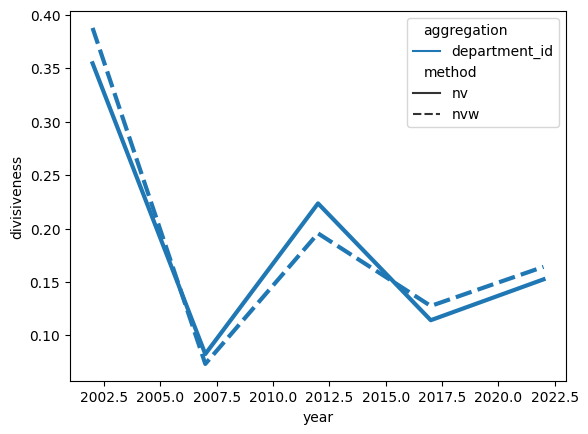

In [151]:
sns.lineplot(
    x="year", 
    y="divisiveness", 
    hue="aggregation", 
    style="method", 
    lw=3, 
    data=dd[dd["method"].isin(["nv", "nvw"])]
)

<AxesSubplot: xlabel='year', ylabel='value_log'>

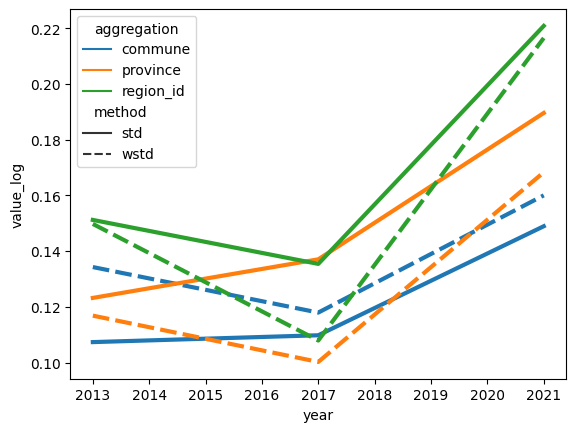

In [48]:
sns.lineplot(
    x="year", 
    y="value_log", 
    hue="aggregation", 
    style="method", 
    lw=3, 
    data=df_maup[df_maup["method"] != "er"]
)